In [91]:
from tools.transcripts import *
from tools.psl import *
import pandas as pd
from tools.mathOps import *
from tools.nameConversions import *

In [2]:
genomes = ("Chimp", "Gibbon", "Gorilla", "Orangutan", "Rhesus")
new_dir = '/public/groups/cgl/cat/primates_evan/work/transMap'
old_dir = '/public/groups/cgl/cat/primates_evan/original_primates/work/transMap/'


In [12]:
def load_metrics(genome, psl_dict):
    m = [[genome, strip_alignment_numbers(x.q_name), x.coverage, x.identity] for x in psl_dict.values()]
    return pd.DataFrame(m, columns=['Genome', 'TranscriptId', 'Coverage', 'Identity'])

gene_sets = []
for genome in genomes:
    new_psl = get_alignment_dict(f'{new_dir}/{genome}.filtered.psl')
    old_psl = get_alignment_dict(f'{old_dir}/{genome}.filtered.psl')
    new_metrics_df = load_metrics(genome, new_psl)
    old_metrics_df = load_metrics(genome, old_psl)
    merged = new_metrics_df.merge(old_metrics_df, on=['Genome', 'TranscriptId'], 
                                  suffixes=['_NewAssembly', '_OriginalAssembly'])
    gene_sets.append(merged)
df = pd.concat(gene_sets)

In [13]:
%matplotlib inline
import seaborn as sns

In [21]:
df['d(Identity)'] = 100.0 * (df['Identity_NewAssembly'] - df['Identity_OriginalAssembly'])
df['d(Coverage)'] = 100.0 * (df['Coverage_NewAssembly'] - df['Coverage_OriginalAssembly'])

In [22]:
m = df[['Genome', 'd(Identity)', 'd(Coverage)']].melt(id_vars=['Genome'])

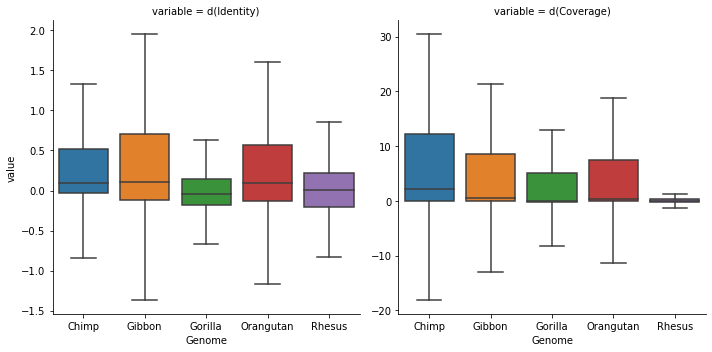

In [26]:
sns.catplot(data=m[m.value != 0], kind='box', x='Genome', y='value', col='variable', showfliers=False,
           sharey=False, order=genomes)

In [55]:
counts = []
for (genome, variable), d in m.groupby(['Genome', 'variable']):
    num_zero = len(d[d.value == 0])
    num_nonzero = len(d) - num_zero
    counts.append([genome, variable, num_zero, num_nonzero])
cdf = pd.DataFrame(counts, columns=['Genome', 'Metric', 'Unchanged', 'Changed'])
cdf = cdf.melt(id_vars=['Genome', 'Metric'])

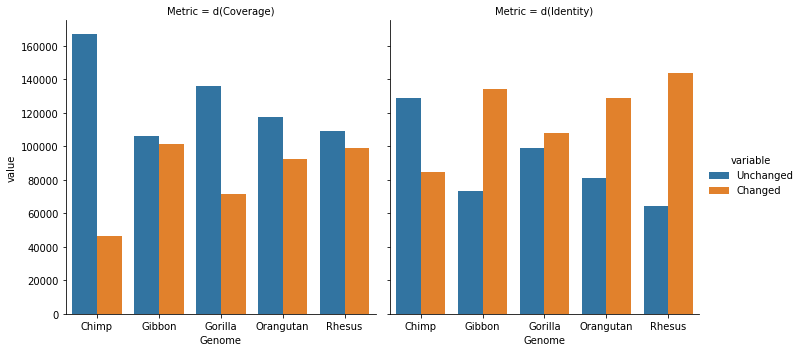

In [58]:
sns.catplot(data=cdf, hue='variable', y='value', x='Genome', col='Metric', kind='bar')

In [59]:
# compare IsoSeq mappability
import pysam
from glob import glob

In [77]:
import os
os.chdir('/public/groups/cgl/cat/primates_evan/')
flnc = glob('isoseq/*/*fasta')

bam_map = defaultdict(list)

for f in flnc:
    g = f.split('/')[1].split('_')[0]
    g = g.title()
    new_bam = f.replace('fasta', 'sorted.bam')
    assert os.path.exists(new_bam)
    old_bam = new_bam.replace('isoseq/', 'isoseq_original_primates/')
    if not os.path.exists(old_bam):
        continue
    bam_map[g].append([new_bam, old_bam])

In [108]:
def filter_bam(bam):
    for rec in pysam.Samfile(bam):
        if not x.is_supplementary and not x.is_secondary and not rec.is_unmapped and rec.seq is not None:
            yield rec
            

def parse_cigar(rec):
    matches = 0
    for op, num_bases in rec.cigar:
        if op == 0:
            matches += num_bases
    return rec.qname, format_ratio(matches, len(rec.seq))


def bam_wapper(bam):
    for rec in filter_bam(bam):
        yield parse_cigar(rec)

In [109]:
metrics = []
for genome, bams in bam_map.items():
    for new_bam, old_bam in bams:
        new_bam = pd.DataFrame(list(bam_wapper(new_bam)), columns=['qname', 'coverage'])
        old_bam = pd.DataFrame(list(bam_wapper(old_bam)), columns=['qname', 'coverage'])
        m = new_bam.merge(old_bam, how='outer', on='qname', suffixes=['_new', '_old'])
        m['genome'] = [genome] * len(m)
        metrics.append(m)

In [110]:
metrics_df = pd.concat(metrics)

In [112]:
metrics_df['delta(Coverage)'] = metrics_df['coverage_new'] - metrics_df['coverage_old']

In [115]:
m = metrics_df[['delta(Coverage)', 'genome']].melt(id_vars=['genome'])

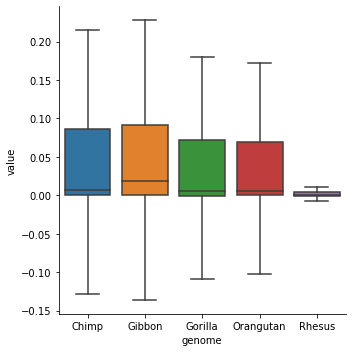

In [118]:
g = sns.catplot(data=m[m.value != 0], y='value', x='genome', kind='box', showfliers=False, order=genomes)

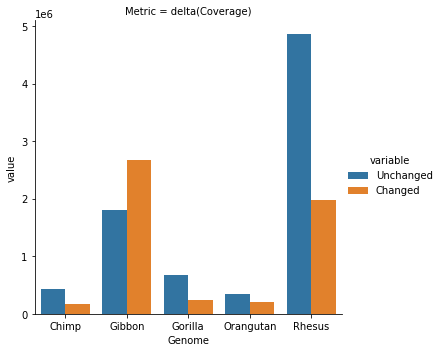

In [120]:
counts = []
for (genome, variable), d in m.groupby(['genome', 'variable']):
    num_zero = len(d[d.value == 0])
    num_nonzero = len(d) - num_zero
    tot = len(d)
    counts.append([genome, variable, 100.0 * num_zero, num_nonzero])
cdf = pd.DataFrame(counts, columns=['Genome', 'Metric', 'Unchanged', 'Changed'])
cdf = cdf.melt(id_vars=['Genome', 'Metric'])
sns.catplot(data=cdf, hue='variable', y='value', x='Genome', col='Metric', kind='bar')